# Polynomial Overfitting Example (Section 7.1)

**The Problem**: More parameters always improve fit to training data, but this doesn't mean better predictions!

**Example**: Primate brain volume vs body mass
- 7 species (small dataset!)
- Fit polynomials of degree 1, 2, 3, 4, 5, 6
- Watch R² improve while models become absurd

**Key Lesson**: We need measures beyond R² to evaluate models!

---

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


## Load Primate Brain Data

From Statistical Rethinking - brain volume and body mass for 7 primate species.

In [17]:
# Load the data
# Note: This is a small dataset from the book
# Species: Different primates
# brain: Brain volume (cc)
# mass: Body mass (kg)

# Create the dataset (from the book)
data = pd.DataFrame({
    'species': ['afarensis', 'africanus', 'habilis', 'boisei',
                'rudolfensis', 'ergaster', 'sapiens'],
    'brain': [438, 452, 612, 521, 752, 871, 1350],
    'mass': [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
})

print(f"Dataset: {len(data)} primate species")
print("\nData:")
data

Dataset: 7 primate species

Data:


,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


In [18]:
# Standardize the variables
# Mass: z-score standardization (typical for predictors)
# Brain: scale to [0, 1] so zero = no brain, one = max brain (better for priors!)
mass_std = (data['mass'] - data['mass'].mean()) / data['mass'].std()
brain_scaled = data['brain'] / data['brain'].max()

print("Variables scaled:")
print(f"Brain (scaled to [0,1]): min={brain_scaled.min():.3f}, max={brain_scaled.max():.3f}")
print(f"Mass (standardized): mean={mass_std.mean():.2f}, std={mass_std.std():.2f}")
print("\n✓ Brain scaling: 0 = no brain, 1 = largest brain (sapiens)")
print("  This makes priors more interpretable!")

Variables scaled:
Brain (scaled to [0,1]): min=0.324, max=1.000
Mass (standardized): mean=0.00, std=1.00

✓ Brain scaling: 0 = no brain, 1 = largest brain (sapiens)
  This makes priors more interpretable!


## Fit Polynomial Models of Increasing Degree

We'll fit 6 models:
1. **Linear** (degree 1): μ = α + β₁x
2. **Quadratic** (degree 2): μ = α + β₁x + β₂x²
3. **Cubic** (degree 3): μ = α + β₁x + β₂x² + β₃x³
4. **Quartic** (degree 4): μ = α + β₁x + ... + β₄x⁴
5. **Quintic** (degree 5): μ = α + β₁x + ... + β₅x⁵
6. **Sextic** (degree 6): μ = α + β₁x + ... + β₆x⁶

**Prediction**: R² will improve with each degree, but models will become absurd!

In [19]:
# Function to fit polynomial of given degree
def fit_polynomial(x, y, degree):
    """
    Fit a polynomial regression of given degree using quap.
    
    Model: y ~ Normal(μ, σ)
           μ = α + β₁x + β₂x² + ... + βₙxⁿ
    
    Priors (adjusted for y in [0, 1]):
        α ~ Normal(0.5, 1)    # Intercept around middle of [0,1]
        β ~ Normal(0, 10)     # Weakly informative for slopes
        σ ~ Exponential(1)    # Error on [0,1] scale
    
    Note: For degree 6, σ is fixed at 0.001 (following the book)
          because with 7 data points and 8 parameters, the model
          is overparameterized and the Hessian becomes singular.
    """
    # Create polynomial features
    X_poly = np.column_stack([x**i for i in range(1, degree + 1)])
    
    # Special case for degree 6: fix sigma at 0.001 (from the book)
    if degree == 6:
        # Fixed sigma version
        def neg_log_posterior(params):
            alpha = params[0]
            betas = params[1:degree+1]
            sigma = 0.001  # Fixed!
            
            # Linear predictor
            mu = alpha + np.sum(X_poly * betas, axis=1)
            
            # Log likelihood
            log_lik = np.sum(stats.norm.logpdf(y, loc=mu, scale=sigma))
            
            # Priors
            log_prior = (stats.norm.logpdf(alpha, 0.5, 1) +
                        np.sum(stats.norm.logpdf(betas, 0, 10)))
            
            return -(log_lik + log_prior)
        
        # Initial parameters: alpha, beta1, ..., beta6 (no log_sigma!)
        initial = [0.5] + [0] * degree
        param_names = ['alpha'] + [f'beta{i}' for i in range(1, degree+1)]
        
        # Fit with quap
        fit = quap(neg_log_posterior, initial, param_names)
        
        # Manually add sigma to the result for consistency
        # We'll store it as a fixed value
        fit._fixed_sigma = 0.001
        
        return fit
    
    else:
        # Normal case: estimate sigma
        def neg_log_posterior(params):
            alpha = params[0]
            betas = params[1:degree+1]
            log_sigma = params[degree+1]
            sigma = np.exp(log_sigma)
            
            # Linear predictor
            mu = alpha + np.sum(X_poly * betas, axis=1)
            
            # Log likelihood
            log_lik = np.sum(stats.norm.logpdf(y, loc=mu, scale=sigma))
            
            # Priors (adjusted for y in [0, 1])
            log_prior = (stats.norm.logpdf(alpha, 0.5, 1) +
                        np.sum(stats.norm.logpdf(betas, 0, 10)) +
                        stats.expon.logpdf(sigma, scale=1))
            
            return -(log_lik + log_prior + log_sigma)
        
        # Initial parameters: alpha, beta1, ..., betan, log_sigma
        initial = [0.5] + [0] * degree + [np.log(0.5)]
        param_names = ['alpha'] + [f'beta{i}' for i in range(1, degree+1)] + ['log_sigma']
        
        # Fit with quap
        fit = quap(neg_log_posterior, initial, param_names)
        fit.transform_param('log_sigma', 'sigma', np.exp)
        
        return fit

print("✓ Polynomial fitting function defined")
print("  Priors adjusted for brain in [0, 1] range")
print("  Degree 6: σ fixed at 0.001 (overparameterized otherwise!)")

✓ Polynomial fitting function defined
  Priors adjusted for brain in [0, 1] range
  Degree 6: σ fixed at 0.001 (overparameterized otherwise!)


In [20]:
# Fit all 6 models
models = {}
degrees = range(1, 7)

for deg in degrees:
    print(f"\nFitting polynomial degree {deg}...")
    models[deg] = fit_polynomial(mass_std.values, brain_scaled.values, deg)
    print(f"  ✓ Converged: {models[deg].success}")

print("\n✓ All models fitted!")


Fitting polynomial degree 1...
✓ Registered transformation: log_sigma -> sigma
  ✓ Converged: True

Fitting polynomial degree 2...
✓ Registered transformation: log_sigma -> sigma
  ✓ Converged: True

Fitting polynomial degree 3...
✓ Registered transformation: log_sigma -> sigma
  ✓ Converged: True

Fitting polynomial degree 4...
✓ Registered transformation: log_sigma -> sigma
  ✓ Converged: True

Fitting polynomial degree 5...
⚠️  Warning: Optimization may not have converged!
   Message: Desired error not necessarily achieved due to precision loss.
✓ Registered transformation: log_sigma -> sigma
  ✓ Converged: False

Fitting polynomial degree 6...
⚠️  Warning: Optimization may not have converged!
   Message: Desired error not necessarily achieved due to precision loss.
  ✓ Converged: False

✓ All models fitted!


## Compute R² for Each Model

**R²** measures proportion of variance explained.

**Watch**: R² will increase monotonically as we add parameters!

In [21]:
# Compute R² for each model
def compute_r_squared(model, x, y, degree):
    """
    Compute R² for a fitted polynomial model.
    """
    # Get coefficients
    coefs = model.coef()
    alpha = coefs['alpha']
    betas = [coefs[f'beta{i}'] for i in range(1, degree+1)]
    
    # Predictions
    X_poly = np.column_stack([x**i for i in range(1, degree + 1)])
    y_pred = alpha + np.sum(X_poly * betas, axis=1)
    
    # R²
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared

# Compute R² for all models
r_squared_values = {}
for deg in degrees:
    r_squared_values[deg] = compute_r_squared(models[deg], 
                                              mass_std.values, 
                                              brain_scaled.values, 
                                              deg)

# Display results
results_df = pd.DataFrame({
    'Degree': list(degrees),
    'Parameters': [deg + 2 if deg < 6 else deg + 1 for deg in degrees],  # Degree 6: σ fixed, not estimated
    'R²': [r_squared_values[deg] for deg in degrees]
})

print("\nModel Comparison (by R²):")
print("="*50)
print(results_df.to_string(index=False))
print("="*50)
print("\n⚠️ Notice: R² increases monotonically!")
print("   But are higher degree models really better?")
print("\n📝 Note: Degree 6 has σ fixed at 0.001 (not estimated)")
print("   With 7 data points, 8 parameters would be overparameterized!")


Model Comparison (by R²):
 Degree  Parameters       R²
      1           3 0.490156
      2           4 0.535946
      3           5 0.679760
      4           6 0.814269
      5           7 0.988852
      6           7 1.000000

⚠️ Notice: R² increases monotonically!
   But are higher degree models really better?

📝 Note: Degree 6 has σ fixed at 0.001 (not estimated)
   With 7 data points, 8 parameters would be overparameterized!


## Visualize the Fits - Recreate Figure 7.1

Let's plot all 6 polynomial fits to see how they become increasingly wiggly and absurd!

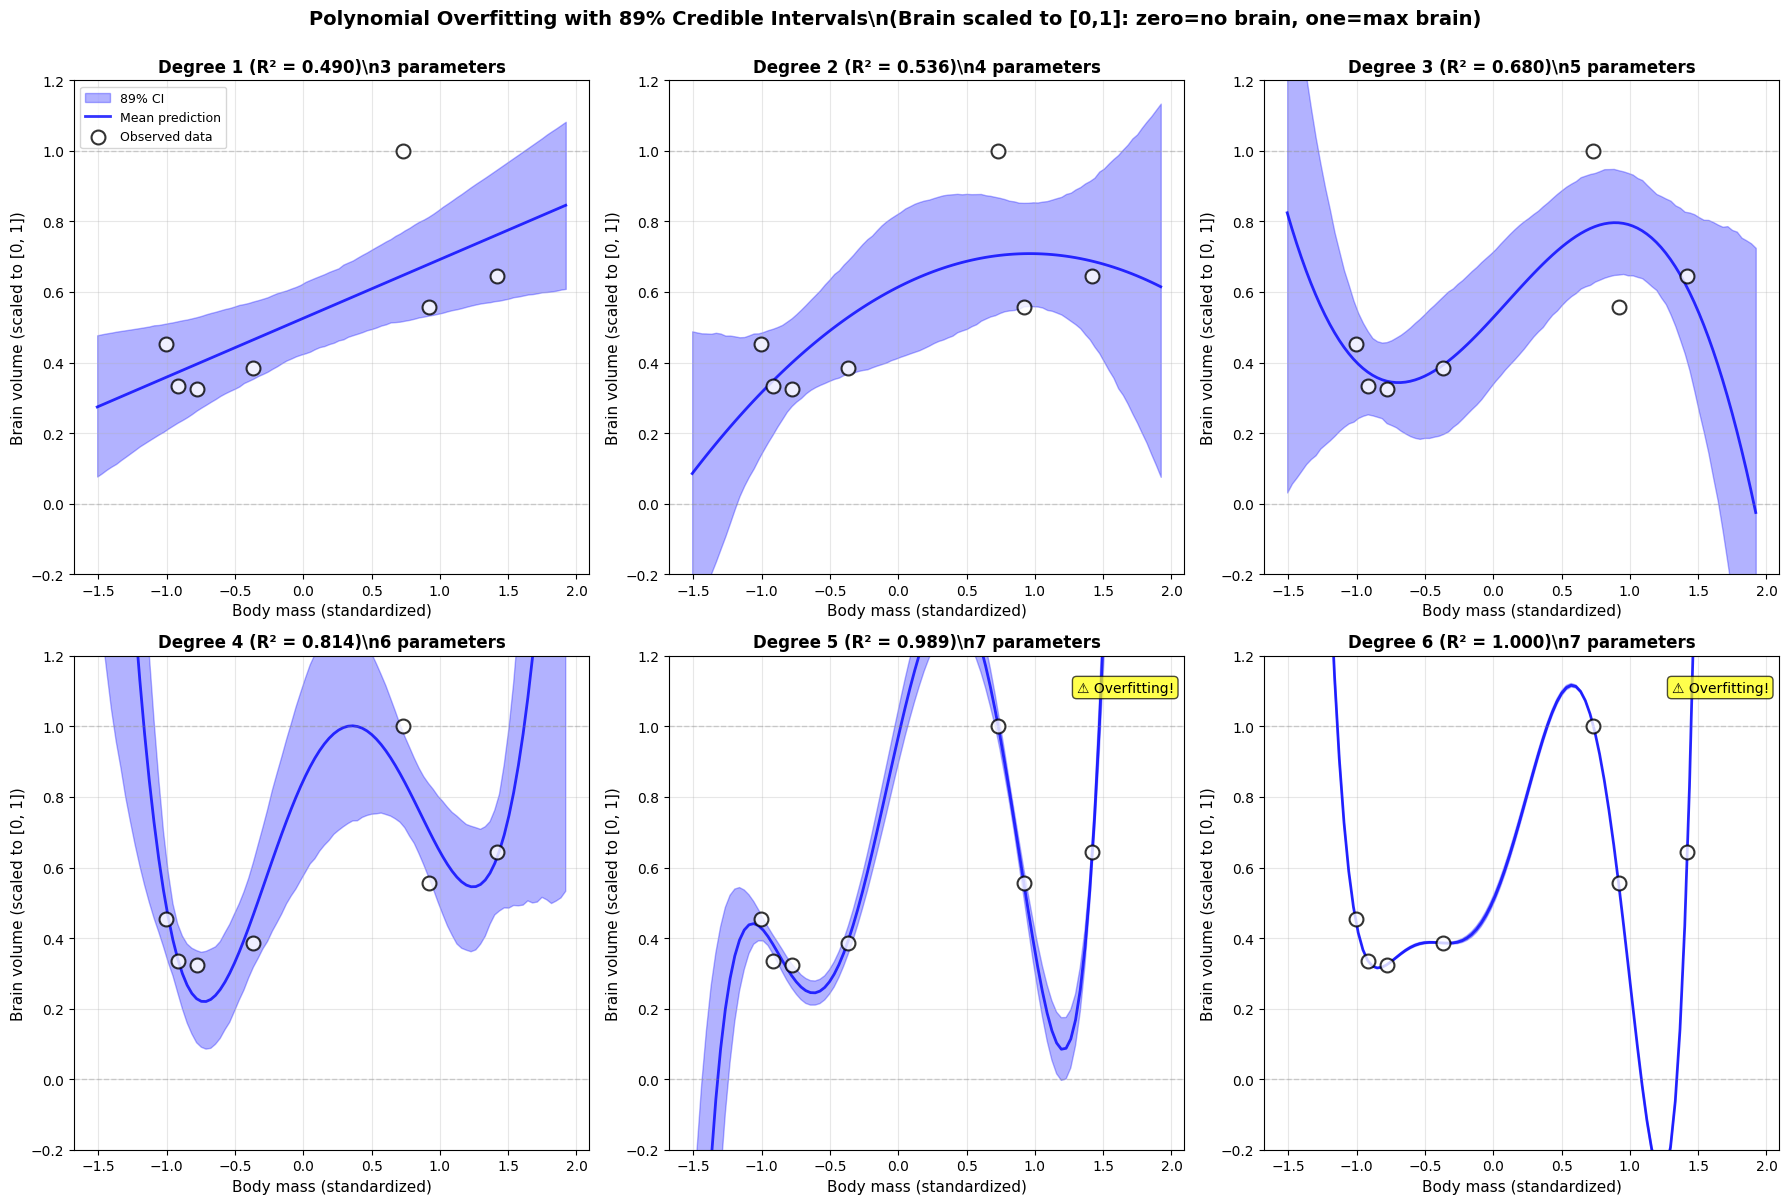

\nObservations:
  • Degree 1-2: Reasonable fits with narrow uncertainty
  • Degree 3-4: Starting to wiggle, uncertainty increases
  • Degree 5-6: Absurdly wiggly with HUGE uncertainty!
\n  Despite improving R², higher degrees are:
    - More uncertain (wider credible intervals)
    - Less realistic (wild wiggles)
    - Worse models!
\n✓ The shaded regions show 89% credible intervals
  Notice how uncertainty explodes for overfit models!


In [22]:
# Create predictions for smooth curves
x_plot = np.linspace(mass_std.min() - 0.5, mass_std.max() + 0.5, 100)

# Function to generate predictions with credible intervals
def predict_polynomial_with_intervals(model, x, degree, n_samples=1000, prob=0.89):
    """
    Generate mean predictions and credible intervals.
    
    Returns:
        y_mean: Mean prediction at each x
        y_lower: Lower bound of credible interval
        y_upper: Upper bound of credible interval
    """
    # Sample from posterior
    samples = model.sample(n=n_samples, seed=42)
    
    # Get polynomial features
    X_poly = np.column_stack([x**i for i in range(1, degree + 1)])
    
    # Generate predictions for each posterior sample
    predictions = np.zeros((n_samples, len(x)))
    
    for i in range(n_samples):
        alpha = samples.iloc[i]['alpha']
        betas = [samples.iloc[i][f'beta{j}'] for j in range(1, degree+1)]
        
        predictions[i, :] = alpha + np.sum(X_poly * betas, axis=1)
    
    # Compute mean and credible interval
    y_mean = predictions.mean(axis=0)
    
    # 89% credible interval (5.5th to 94.5th percentile)
    alpha_level = 1 - prob
    y_lower = np.percentile(predictions, (alpha_level/2) * 100, axis=0)
    y_upper = np.percentile(predictions, (1 - alpha_level/2) * 100, axis=0)
    
    return y_mean, y_lower, y_upper

# Plot all models with credible intervals
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, deg in enumerate(degrees):
    ax = axes[i]
    
    # Get predictions with intervals
    y_mean, y_lower, y_upper = predict_polynomial_with_intervals(
        models[deg], x_plot, deg, n_samples=1000, prob=0.89
    )
    
    # Plot 89% credible interval (shaded region)
    ax.fill_between(x_plot, y_lower, y_upper, 
                    alpha=0.3, color='blue', label='89% CI')
    
    # Plot mean prediction line
    ax.plot(x_plot, y_mean, 'b-', linewidth=2, alpha=0.8, 
           label='Mean prediction', zorder=2)
    
    # Plot data points on top
    ax.scatter(mass_std, brain_scaled, s=100, alpha=0.8, 
              edgecolor='black', linewidth=1.5, zorder=3,
              color='white', label='Observed data')
    
    # Formatting
    ax.set_xlabel('Body mass (standardized)', fontsize=11)
    ax.set_ylabel('Brain volume (scaled to [0, 1])', fontsize=11)
    ax.set_title(f'Degree {deg} (R² = {r_squared_values[deg]:.3f})\\n' + 
                f'{deg + 2 if deg < 6 else deg + 1} parameters',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.2)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(1, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Legend only on first plot
    if i == 0:
        ax.legend(loc='upper left', fontsize=9)
    
    # Add annotation for absurd models
    if deg >= 5:
        ax.text(0.98, 0.95, '⚠️ Overfitting!', 
               transform=ax.transAxes, fontsize=10,
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.suptitle('Polynomial Overfitting with 89% Credible Intervals\\n' +
            '(Brain scaled to [0,1]: zero=no brain, one=max brain)', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\\nObservations:")
print("  • Degree 1-2: Reasonable fits with narrow uncertainty")
print("  • Degree 3-4: Starting to wiggle, uncertainty increases")
print("  • Degree 5-6: Absurdly wiggly with HUGE uncertainty!")
print("\\n  Despite improving R², higher degrees are:")
print("    - More uncertain (wider credible intervals)")
print("    - Less realistic (wild wiggles)")
print("    - Worse models!")
print("\\n✓ The shaded regions show 89% credible intervals")
print("  Notice how uncertainty explodes for overfit models!")

## The Problem: R² Always Increases!

Let's visualize how R² changes with model complexity:

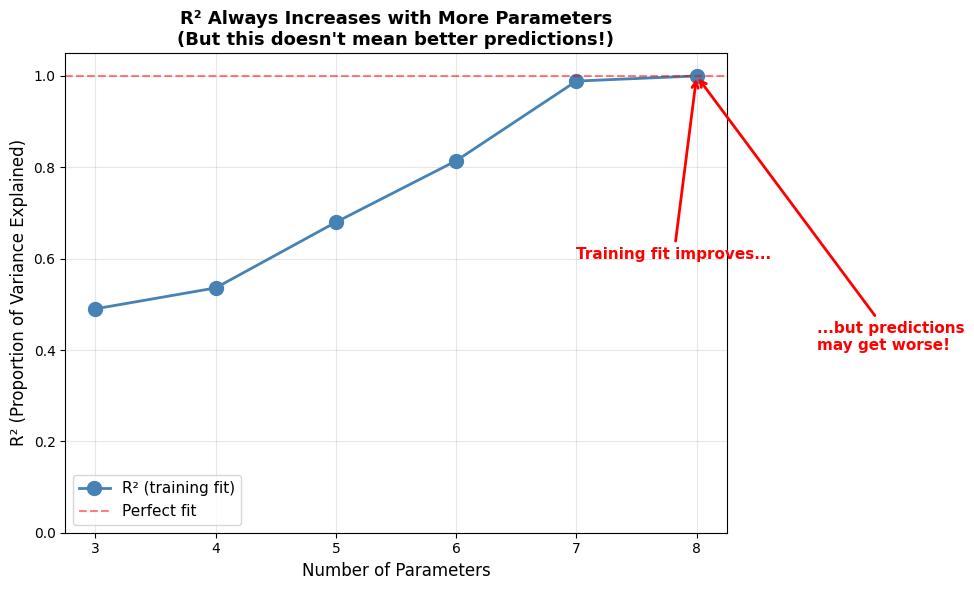


⚠️ THE PROBLEM:
   R² is NOT a good measure of model quality!
   It always improves with more parameters.

✓ WE NEED:
   - Measures that penalize complexity
   - Out-of-sample validation
   - Information criteria (WAIC, LOO)


In [15]:
# Plot R² vs number of parameters
fig, ax = plt.subplots(figsize=(10, 6))

n_params = [deg + 2 for deg in degrees]  # +2 for alpha and sigma
r2_values = [r_squared_values[deg] for deg in degrees]

ax.plot(n_params, r2_values, 'o-', linewidth=2, markersize=10, 
       color='steelblue', label='R² (training fit)')
ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Perfect fit')

ax.set_xlabel('Number of Parameters', fontsize=12)
ax.set_ylabel('R² (Proportion of Variance Explained)', fontsize=12)
ax.set_title('R² Always Increases with More Parameters\n(But this doesn\'t mean better predictions!)', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

# Annotate the problem
ax.annotate('Training fit improves...', 
           xy=(8, r2_values[-1]), xytext=(7, 0.6),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           fontsize=11, color='red', fontweight='bold')

ax.annotate('...but predictions\nmay get worse!', 
           xy=(8, r2_values[-1]), xytext=(9, 0.4),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           fontsize=11, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ THE PROBLEM:")
print("   R² is NOT a good measure of model quality!")
print("   It always improves with more parameters.")
print("\n✓ WE NEED:")
print("   - Measures that penalize complexity")
print("   - Out-of-sample validation")
print("   - Information criteria (WAIC, LOO)")

---

## Key Lessons

### 1. R² is Misleading
- R² always increases (or stays same) with more parameters
- Perfect R² = 1.0 with N parameters for N data points
- **But** this doesn't mean good predictions!

### 2. Visual Inspection Reveals Absurdity
- Degree 5-6 polynomials are clearly ridiculous
- Wiggly curves that fit noise, not signal
- Would make terrible predictions on new species

### 3. We Need Better Measures
To evaluate models properly, we need:

**Option 1: Information Criteria**
- WAIC, AIC, DIC
- Balance fit vs complexity automatically
- Coming in next sections!

**Option 2: Cross-Validation**
- Test on held-out data
- Direct measure of predictive accuracy
- Gold standard but expensive

**Option 3: Regularization**
- Skeptical priors that resist complexity
- Built into the model itself

### 4. The Overfitting Paradox
> **"Better fit to training data can mean worse predictions!"**

This is why we can't just maximize R² or minimize training error.

---

## Next Steps

In the following notebooks, we'll learn:
1. **Information theory** - Why overfitting happens (entropy, KL divergence)
2. **WAIC** - How to compute and use it for model comparison
3. **Cross-validation** - Direct out-of-sample testing
4. **Regularization** - Using priors to prevent overfitting

These tools will help us choose models wisely!

## Underfitting vs Overfitting: Sensitivity to Data

**Key Insight**: Let's see what happens when we drop a single observation!

- **Underfit model (degree 1)**: Dropping one point barely changes the fit
  - Model is too simple to be heavily influenced by individual points
  
- **Overfit model (degree 6)**: Dropping one point drastically changes the fit
  - Model is "memorizing" each data point
  - Remove one point = whole fit changes!

This demonstrates the **fragility of overfit models**.

In [ ]:
# Demonstrate sensitivity by dropping observations
# We'll drop 3 different observations to show the effect

observations_to_drop = [2, 5, 6]  # Indices to drop (arbitrary choices)
colors = ['red', 'green', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for model_idx, (deg, title) in enumerate([(1, 'UNDERFIT (Degree 1)'), 
                                           (6, 'OVERFIT (Degree 6)')]):
    ax = axes[model_idx]
    
    # Plot full data fit (reference)
    y_mean_full, y_lower_full, y_upper_full = predict_polynomial_with_intervals(
        models[deg], x_plot, deg, n_samples=1000, prob=0.89
    )
    
    ax.fill_between(x_plot, y_lower_full, y_upper_full,
                   alpha=0.2, color='gray', label='Full data (89% CI)')
    ax.plot(x_plot, y_mean_full, 'k-', linewidth=3, alpha=0.7,
           label='Full data fit', zorder=2)
    
    # Plot all data points
    ax.scatter(mass_std, brain_scaled, s=100, alpha=0.6,
              edgecolor='black', linewidth=1.5, zorder=3,
              color='lightgray', label='All observations')
    
    # Now fit models leaving out each observation
    for i, (drop_idx, color) in enumerate(zip(observations_to_drop, colors)):
        # Create data with one observation dropped
        mask = np.ones(len(mass_std), dtype=bool)
        mask[drop_idx] = False
        
        x_loo = mass_std.values[mask]
        y_loo = brain_scaled.values[drop_idx]
        
        # Fit model without this observation
        try:
            model_loo = fit_polynomial(mass_std.values[mask], 
                                      brain_scaled.values[mask], 
                                      deg)
            
            # Get predictions
            coefs = model_loo.coef()
            alpha_loo = coefs['alpha']
            betas_loo = [coefs[f'beta{j}'] for j in range(1, deg+1)]
            
            X_poly_plot = np.column_stack([x_plot**j for j in range(1, deg + 1)])
            y_pred_loo = alpha_loo + np.sum(X_poly_plot * betas_loo, axis=1)
            
            # Plot the leave-one-out fit
            ax.plot(x_plot, y_pred_loo, '--', linewidth=2, alpha=0.7,
                   color=color, label=f'Drop obs #{drop_idx}')
            
            # Highlight the dropped observation
            ax.scatter(mass_std.iloc[drop_idx], brain_scaled.iloc[drop_idx],
                      s=200, alpha=0.9, edgecolor='black', linewidth=2,
                      color=color, marker='X', zorder=10)
            
        except Exception as e:
            print(f"Warning: Could not fit degree {deg} without obs {drop_idx}: {e}")
    
    # Formatting
    ax.set_xlabel('Body mass (standardized)', fontsize=12)
    ax.set_ylabel('Brain volume (scaled to [0, 1])', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.2)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(1, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.legend(loc='upper left', fontsize=9)

plt.suptitle('Sensitivity to Individual Observations: Underfit vs Overfit',
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print("\n📊 UNDERFIT MODEL (Degree 1):")
print("  • Dropping any single point barely changes the fit")
print("  • All lines are nearly on top of each other")
print("  • Model is STABLE but may be too simple")
print("  • Underfits = high bias, low variance")

print("\n📊 OVERFIT MODEL (Degree 6):")
print("  • Dropping a single point DRASTICALLY changes the fit!")
print("  • Each line wiggles differently")
print("  • Model is FRAGILE - memorizing each data point")
print("  • Overfits = low bias, high variance")

print("\n💡 THE LESSON:")
print("  Good models should be:")
print("    ✓ Stable (not too sensitive to individual points)")
print("    ✓ Flexible (capture real patterns)")
print("    ✓ Generalizable (predict new data well)")
print("\n  Degree 1: Too stable (rigid)")
print("  Degree 6: Too fragile (memorizing)")
print("  Degree 2-3: Just right! (balanced)")
print("="*70)